# IBM Watson Machine Learning: Deploy IMDB reviews sentiment analyses

This notebook uses Kaggle dataset (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

### Contents

1. [Set up the environment](#setup_environment)
1. [Explore and prepare training data](#explore_prepare_data)
1. [Create train and test dataset](#train_test_set)
1. [Train the model](#train_model)
1. [Save the model](#save_model)
1. [Deploy and score](#deploy_model)

In [1]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import json

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics

In [ ]:
import ssl

# This try-except block addresses SSL certificate verification issues.
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>


False

<a id="setup_environment"></a>
## 1. Set up the environment

To authenticate to Watson Machine Learning in the IBM Cloud, you need api_key and service location.

Using [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) or directly through the IBM Cloud portal.

Using IBM Cloud CLI:

```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

NOTE: To get the Service URL [Endpoint URLs section of the Watson Machine Learning docs](https://cloud.ibm.com/apidocs/machine-learning).

**Action**: Enter your api_key and location in the following cell.

In [ ]:
API_KEY = 'API_KEY'
LOCATION = 'LOCATION'

In [ ]:
WML_CREDENTIALS = {
    "apikey": API_KEY,
    "url": LOCATION
}

**Action**: Assign space ID below

In [ ]:
SPACE_ID = 'SPACE_ID'

**Action**: Assign project ID below

In [ ]:
PROJECT_ID = 'PROJECT_ID'

### 1.2 Installing IBM Watson Machine Learning library

NOTE: Documentation could be found [here](http://ibm-wml-api-pyclient.mybluemix.net/)

In [ ]:
%pip install -U ibm-watson-machine-learning --quiet

In [ ]:
from ibm_watson_machine_learning import APIClient

wml_client = APIClient(WML_CREDENTIALS)
print(wml_client.version)

<a id="explore_prepare_data"></a>
## 2. Explore and prepare training data

### 2.1 Importing training data

NOTE: read from `/data` directory if running locally

In [4]:
df = pd.read_csv('../data/imdb_dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### 2.2. Exploring and preparing data

In [ ]:
df.describe()

Text(0.5, 1.0, 'Sentiment label distribution')

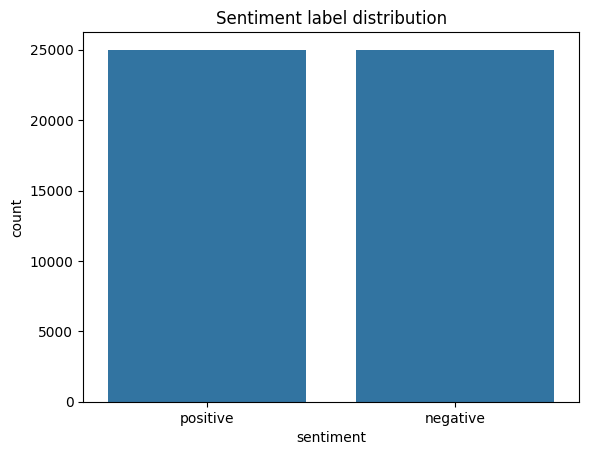

In [5]:
ax = sns.countplot(x="sentiment", data=df)
plt.title("Sentiment label distribution")

In this step you will prepare data for training a model. Using the following Text Feature Engineering techniques:

1. Tonkenization         
2. Removes stop words
3. Stemming text (porter)
4. Joining words (tokens) into a single string

In [6]:
stop_words = stopwords.words('english')
porter_stemmer = PorterStemmer()

In [7]:
def tokenization(text):
    """Tokenizes the input text into a list of tokens.

    Args:
        text (str): The input text to be tokenized

    Returns:
        list: A list containing tokens extracted from the input text
    """
    tokens = word_tokenize(text)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

In [8]:
def remove_stop_words(tokens):
    """Remove stop words from a list of tokens

    Args:
        tokens (list): A list of tokens from which stop words will be removed

    Returns:
        list: A list of tokens with stop words removed
    """
    stop = [w for w in tokens if not w in stop_words]
    return (stop)

In [9]:
def stem_porter(tokens):
    """Execute Porter stemming on a list of tokens

    Args:
        row (list): A list of tokens to apply stemming

    Returns:
        list: A list of tokens after stemming
    """
    stemmed_list = [porter_stemmer.stem(word) for word in tokens]
    return (stemmed_list)

In [10]:
def rejoin_words(tokens):
    """Join tokens in a single string

    Args:
        tokens (list of str): List of tokens to be joined

    Returns:
        str: The text obtained by joining the tokens with spaces
    """
    joined_words = (" ".join(tokens))
    return joined_words

In [11]:
def pre_processing(df, column):
    """Execute text feature engineering (TFE)
    Args:
        df (dataframe): row of dataframe
        column: column containing text to be processed
    Returns:
        list: Text post text feature engineering (TFE)
    """  
    df_col = df[column]

    input_tokens = df_col.apply(tokenization)
    input_tokens = input_tokens.apply(remove_stop_words)
    input_tokens = input_tokens.apply(stem_porter)
    input_text_cleaned = input_tokens.apply(rejoin_words)

    df['cleaned_text'] = input_text_cleaned
    
    return df

In [13]:
df = pre_processing(df, "review")

df['cleaned_text'] = df['cleaned_text'].str.lower()
df.head()

<a id="train_test_set"></a>
## 3. Create train and test dataset

NOTE: Test dataset (30%) and Training dataset (70%)

In [ ]:
X = df['cleaned_text']
Y = df['sentiment']

print(X.shape)
print(Y.shape)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

NOTE: Machine Learning or Deep Learning models uses numeric values input. The Tf-Idf Text Feature Engineering (TFE) process will be used to transform the texts into vectors.

In [ ]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(2,3), sublinear_tf=True)

X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

print(Y.value_counts().shape)
print(X_train_tf.shape)

In [ ]:
le = preprocessing.LabelEncoder()

Y_train_le = le.fit_transform(list(Y_train))
Y_test_le = le.transform(list(Y_test))

<a id="train_model"></a>
## 4. Train the model

Create a Scikit-learn models.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# Binary classifiers
# GradientBoostingClassifier
gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(X_train_tf, Y_train_le)
Y_predict_gradient_boost = gradient_boost.predict(X_test_tf)
print('Gradient Boosting Classifier DONE!')

# SVC -- too much time
# svc_model = SVC(gamma='auto', kernel='sigmoid', C=1.8, probability=True)
# svc_model.fit(X_train_tf, Y_train_le)
# Y_predict_svm = svc_model.predict(X_test_tf)
# print('Support Vector Machine(SVM) DONE!')

# RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=10)
random_forest.fit(X_train_tf, Y_train_le)
Y_predict_random_forest = random_forest.predict(X_test_tf)
print('Random Forest Classifier DONE!')

# KNeighborsClassifier
k_neighbors = KNeighborsClassifier()
k_neighbors.fit(X_train_tf, Y_train_le)
Y_predict_k_neighbors = k_neighbors.predict(X_test_tf)
print('K Nearest Neighbor Classifier DONE!')

# LogisticRegression
logistic_regression = LogisticRegression(solver='lbfgs', penalty='l2', C=1.5)
logistic_regression.fit(X_train_tf, Y_train_le)
Y_predict_logistic_regression = logistic_regression.predict(X_test_tf)
print('Logistic Regression DONE!')

### 4.1 Model evaluation

In [ ]:
print('Gradient Boosting Classifier:  ', metrics.accuracy_score(Y_test_le, Y_predict_gradient_boost))
# print('Support Vector Machine(SVM):   ', metrics.accuracy_score(Y_test_le, Y_predict_svm))
print('Random Forest Classifier:      ', metrics.accuracy_score(Y_test_le, Y_predict_random_forest))
print('K Nearest Neighbor Classifier: ', metrics.accuracy_score(Y_test_le, Y_predict_k_neighbors))
print('Logistic Regression:           ', metrics.accuracy_score(Y_test_le, Y_predict_logistic_regression))

### 4.2 Resume of classification

NOTE: Accuracy >= 0.70

In [ ]:
# print('Support vector machine(SVM):\n {}\n'.format(metrics.classification_report(Y_test_le, Y_predict_svm)))
print('Random Forest Classifier:\n {}\n'.format(metrics.classification_report(Y_test_le, Y_predict_random_forest)))
print('Logistic Regression:\n {}\n'.format(metrics.classification_report(Y_test_le, Y_predict_logistic_regression)))

### 4.3 - Logistic Regression

NOTE: Best accuracy model confusion matrix

In [ ]:
logistic_regression_conf_matrix = metrics.confusion_matrix(Y_test_le, Y_predict_logistic_regression)
sns.heatmap(logistic_regression_conf_matrix, annot=True,  fmt='');
plt.title('Confusion matrix, Logistic Regression');

NOTE: Best accuracy model ROC curve

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test_le, Y_predict_logistic_regression)
auc = metrics.roc_auc_score(Y_test_le, Y_predict_logistic_regression)

plt.subplots(figsize=(5,5))
plt.plot(fpr,tpr, label="AUC="+str(auc))
plt.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc=4)
plt.show()

### 4.4 Model selection

In [ ]:
X_train_final = tfidf.fit_transform(X)
Y_train_final = le.fit_transform(list(Y))

print(X_train_final.shape)

In [ ]:
lrc = LogisticRegression(solver='lbfgs', penalty='l2', C=1.5)
lrc.fit(X_train_final, Y_train_final)

<a id="save_model"></a>
## 5. Save the model

### 5.1 Save the model to IBM Watson Studio project

In [ ]:
wml_client.set.default_project(PROJECT_ID)

In [ ]:
sofware_spec_uid = wml_client.software_specifications.get_id_by_name("runtime-22.1-py3.9")
metadata = {
            wml_client.repository.ModelMetaNames.NAME: 'Logistic Regression model to predict IMDB reviews',
            wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0',
            wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

published_model = wml_client.repository.store_model(model=lrc, meta_props=metadata)

### 5.2 Save the model to IBM Watson Studio space

In [ ]:
wml_client.set.default_space(SPACE_ID)

In [ ]:
wml_client.spaces.list(limit=10)

In [ ]:
published_model = wml_client.repository.store_model(model=lrc, meta_props=metadata)

In [ ]:
published_model_uid = wml_client.repository.get_model_id(published_model)
model_details = wml_client.repository.get_details(published_model_uid)
print(json.dumps(model_details, indent=2))

In [ ]:
wml_client.repository.list_models()

In [ ]:
# wml_client.repository.delete(published_model_uid)

<a id="deploy_model"></a>
## 6. Deploy and score

NOTE: Deploy and score the model deployed at IBM Watson Machine Learning

In [ ]:
metadata = {
    wml_client.deployments.ConfigurationMetaNames.NAME: "Deployment of IMDB reviews model",
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = wml_client.deployments.create(published_model_uid, meta_props=metadata)

In [ ]:
# Get deployment UID and show details on the deployment
deployment_uid = wml_client.deployments.get_uid(created_deployment)
wml_client.deployments.get_details(deployment_uid)

In [ ]:
wml_client.deployments.list()

In [ ]:
# wml_client.deployments.delete(deployment_uid)

### 6.1 Score model

NOTE: Test the API created from IBM Watson Machine Learning.

In [ ]:
# get scoring end point
scoring_endpoint = wml_client.deployments.get_scoring_href(created_deployment)
print(scoring_endpoint)

In [ ]:
# add some test data
scoring_payload = {"input_data": [
    {'values': X_test_tf.toarray()
    }]}

In [ ]:
# score the model
predictions = wml_client.deployments.score(deployment_uid, scoring_payload)
print('prediction',json.dumps(predictions, indent=2))

In [ ]:
Y_predict_final_model = []
for y in predictions['predictions'][0]['values']:
    Y_predict_final_model.append(y[0])
    
print('Final Model WML:\n {}\n'.format(metrics.classification_report(Y_test_le, Y_predict_final_model)))